In [25]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../../dmae/src/')
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor, Discriminator
import magic
import torch
import pathlib
import copy
from procrustes import Procrustes
import pickle
import graphtools
import scanpy as sc
from plotly3d.plot import scatter
from tqdm import tqdm

In [26]:
from plotly3d.plot import trajectories

In [27]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')

In [28]:
traj_dict = np.load('../data/traj_dict.npz', allow_pickle=True)

In [29]:
traj_dict.files

['0', '1', '2']

In [30]:
print(traj_dict['0'].shape)
print(traj_dict['1'].shape)
print(traj_dict['2'].shape)

(100, 50, 2)
(100, 50, 2)
(100, 50, 2)


In [31]:
traj = np.concatenate([traj_dict['0'], traj_dict['1'], traj_dict['2']], axis=1)
traj_ids = np.concatenate([np.zeros(traj_dict['0'].shape[1]), np.ones(traj_dict['1'].shape[1]), np.ones(traj_dict['2'].shape[1]) * 2], axis=0)

In [32]:
# traj = torch.load('../data/x_traj.pt')
with open('../data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
traj_flattened = traj.reshape(-1, 2)
traj_flattened = scaler.inverse_transform(traj_flattened)
traj = traj_flattened.reshape(traj.shape[0], traj.shape[1], -1)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning:

Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



In [33]:
wandb.login()
api = wandb.Api()

In [34]:
folder_path = '/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/src/wandb/'
entity = "xingzhis"
project = "dmae"
run_id = 'hdco3l9p'
# run_id = '2ycyrp8z'
# run_id = 'txickx2m'
# run_id = 'kcuupvd2'
# run_id = 'c7io5ycp'


In [35]:
run = api.run(f"{entity}/{project}/{run_id}")
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    # x = torch.tensor(X, dtype=torch.float32, device=model.device)
    z = model.encoder(x).cpu().numpy()
    xh = model.decoder(torch.tensor(z)).cpu().numpy()

proc = Procrustes()
p1, z1, di = proc.fit_transform(data['phate'], z)

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.3.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/dmae/src/wandb/run-20240907_173132-hdco3l9p/files/epoch=24-step=60000.ckpt`
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



In [36]:
z_phate = proc.inverse_transform(data['phate'])
z_phate = torch.tensor(z_phate, dtype=torch.float32, device=model.device)
with torch.no_grad():
    xh_from_phate = model.decoder(z_phate).cpu().numpy()

In [37]:
traj_unprocru = proc.inverse_transform(traj.reshape(-1, 2))
traj_unprocru_reshape = traj_unprocru.reshape(traj.shape[0], traj.shape[1], -1)

In [38]:
fig = scatter(z, adata.obs['day'], title='Latent space', s=3)
trajectories(traj_unprocru_reshape, fig=fig, s=.5)

In [39]:
traj_tensor = torch.tensor(traj_unprocru, dtype=torch.float32, device=model.device)
with torch.no_grad():
    traj_dec = model.decoder(traj_tensor)


In [40]:
traj_dec.shape

torch.Size([15000, 50])

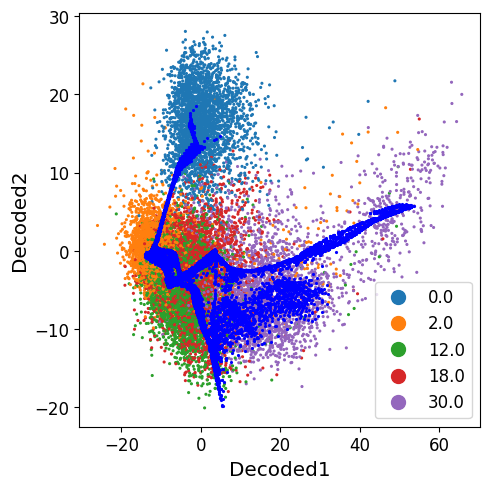

In [41]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
scprep.plot.scatter2d(adata.obsm['X_pca'], c=adata.obs['day'], ticks=True, label_prefix="PCA", ax=ax)
scprep.plot.scatter2d(traj_dec.cpu().numpy(), ticks=True, label_prefix="Decoded", ax=ax, c='b')
plt.tight_layout()
plt.show()

In [42]:
X_recon = (traj_dec.cpu().numpy() @ adata.varm['PCs'].T) + adata.X.toarray().mean(axis=0)

In [43]:
traj_gene_sp = X_recon.reshape(traj.shape[0], traj.shape[1], -1)

In [44]:
# np.save('../data/traj_gene_space.npy', traj_gene_sp)

In [46]:
traj_gene_sp.shape

(100, 150, 21465)

In [50]:
traj_ids.shape

(150,)

In [51]:
np.savez('../data/traj_gene_space.npz', traj=traj_gene_sp, traj_ids=traj_ids)

In [53]:
np.save('../data/traj_gene_space_0.npy', traj_gene_sp[:,traj_ids==0])
np.save('../data/traj_gene_space_1.npy', traj_gene_sp[:,traj_ids==1])
np.save('../data/traj_gene_space_2.npy', traj_gene_sp[:,traj_ids==2])